# Episode Hierarchy Visualization

Visualize the hierarchical episodes/sub-events mined from scene graphs using EpiMine.

**Config**: `t=1.5, mf=2, topk=10, gen=gpt5.1`

**Visual Elements:**
- Overall goal header
- Episode timeline with boundaries
- Episode cards with structure details
- Temporal flow diagram
- Discriminative terms

In [1]:
# Cell 1: Imports & Setup
import sys
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from matplotlib.colors import to_rgba
from IPython.display import display, HTML, Markdown

# Add paths for imports
ROOT_DIR = Path('/home/jtu9/sgg/tsg-bench')
sys.path.insert(0, str(ROOT_DIR))

from visualization import NODE_COLORS

# Load episode hierarchy data
EPISODES_PATH = ROOT_DIR / 'anygran' / 'benchmarks' / 'hard_10' / 'cache' / 'hard10_episodes_t1.5_mf2_topk10_gen51.json'
with open(EPISODES_PATH, 'r') as f:
    episodes_data = json.load(f)

# Load original hard-10 cases for reference
HARD10_PATH = ROOT_DIR / 'anygran' / 'benchmarks' / 'hard_10' / 'sgqa_hard_10.json'
with open(HARD10_PATH, 'r') as f:
    hard10_data = json.load(f)
cases = hard10_data['cases']

# Create data_id to case mapping
case_by_id = {c['data_id']: c for c in cases}

print(f"Loaded {len(episodes_data)} episode hierarchies")
print(f"Data IDs: {list(episodes_data.keys())[:3]}...")

Loaded 9 episode hierarchies
Data IDs: ['860980fb-f992-4bb1-8a46-b644f58090e2', '41b8254c-ca1e-464c-9323-55301fb5f0e8', '312da1d0-9e56-4f5e-bb12-9cb67e8bc674']...


In [2]:
# Cell 2: Color Scheme & Helper Functions

# Episode colors (distinct for each episode)
EPISODE_COLORS = [
    '#3498DB',  # Blue
    '#E74C3C',  # Red
    '#2ECC71',  # Green
    '#9B59B6',  # Purple
    '#F39C12',  # Orange
    '#1ABC9C',  # Teal
    '#E91E63',  # Pink
    '#00BCD4',  # Cyan
]

POSITION_COLORS = {
    'beginning': '#27AE60',
    'middle': '#3498DB',
    'end': '#E74C3C',
}


def get_episode_color(episode_id):
    """Get color for an episode by its ID."""
    return EPISODE_COLORS[episode_id % len(EPISODE_COLORS)]


def display_goal_header(data_id, hierarchy):
    """Display the overall goal header."""
    overall_goal = hierarchy.get('overall_goal', 'No goal specified')
    episodes = hierarchy.get('episodes', [])
    
    # Get case info if available
    case = case_by_id.get(data_id, {})
    question = case.get('question', 'N/A')
    ground_truth = case.get('ground_truth', 'N/A')
    
    html = f"""
    <div style="border: 3px solid #2C3E50; border-radius: 15px; padding: 20px; margin: 15px 0; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white;">
        <h2 style="margin-top: 0; color: white;">Sample: {data_id[:12]}...</h2>
        
        <div style="background: rgba(255,255,255,0.15); padding: 15px; border-radius: 10px; margin: 10px 0;">
            <h3 style="margin: 0 0 10px 0; color: #F1C40F;">Overall Goal</h3>
            <p style="font-size: 16px; margin: 0; font-style: italic;">{overall_goal}</p>
        </div>
        
        <div style="display: flex; gap: 20px; margin-top: 15px;">
            <div style="flex: 1; background: rgba(255,255,255,0.1); padding: 10px; border-radius: 8px;">
                <strong style="color: #F1C40F;">Episodes:</strong> {len(episodes)}
            </div>
            <div style="flex: 1; background: rgba(255,255,255,0.1); padding: 10px; border-radius: 8px;">
                <strong style="color: #F1C40F;">Question:</strong> {question[:50]}{'...' if len(question) > 50 else ''}
            </div>
            <div style="flex: 1; background: rgba(255,255,255,0.1); padding: 10px; border-radius: 8px;">
                <strong style="color: #2ECC71;">Ground Truth:</strong> {ground_truth}
            </div>
        </div>
    </div>
    """
    display(HTML(html))


def create_episode_timeline(hierarchy, figsize=(18, 6)):
    """Create a horizontal timeline showing episode boundaries."""
    episodes = hierarchy.get('episodes', [])
    if not episodes:
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Find total action range
    all_indices = []
    for ep in episodes:
        all_indices.extend(ep.get('time', {}).get('action_indices', []))
    
    if not all_indices:
        return None
    
    min_idx = min(all_indices)
    max_idx = max(all_indices)
    total_range = max_idx - min_idx + 1
    
    # Draw episode bars
    bar_height = 0.6
    y_positions = {}
    
    for i, ep in enumerate(episodes):
        ep_id = ep.get('episode_id', i)
        time_info = ep.get('time', {})
        start = time_info.get('start_index', 0)
        end = time_info.get('end_index', start)
        duration = end - start + 1
        
        color = get_episode_color(ep_id)
        y = len(episodes) - i - 1  # Stack from bottom
        y_positions[ep_id] = y
        
        # Episode bar
        rect = FancyBboxPatch(
            (start, y - bar_height/2), duration, bar_height,
            boxstyle="round,pad=0.02,rounding_size=0.2",
            facecolor=color, edgecolor='white', linewidth=2, alpha=0.85
        )
        ax.add_patch(rect)
        
        # Episode label
        name = ep.get('name', f'Episode {ep_id}')
        if len(name) > 20:
            name = name[:18] + '..'
        ax.text(start + duration/2, y, name, ha='center', va='center',
                fontsize=9, fontweight='bold', color='white')
        
        # Duration label
        ax.text(start + duration/2, y - 0.35, f'[{start}-{end}] ({duration} actions)',
                ha='center', va='top', fontsize=7, color='gray')
        
        # Salience score
        salience = ep.get('salience_score', 0)
        ax.text(end + 0.5, y, f'{salience:.2f}', ha='left', va='center',
                fontsize=8, color=color, fontweight='bold')
    
    # Add legend
    legend_elements = []
    for i, ep in enumerate(episodes):
        ep_id = ep.get('episode_id', i)
        color = get_episode_color(ep_id)
        name = ep.get('name', f'Episode {ep_id}')
        legend_elements.append(
            mpatches.Patch(facecolor=color, label=f'E{ep_id}: {name[:25]}', edgecolor='white')
        )
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, framealpha=0.95)
    
    # Frame markers on x-axis
    ax.set_xlim(min_idx - 1, max_idx + 3)
    ax.set_ylim(-1, len(episodes))
    
    # Add frame ticks
    ax.set_xticks(range(min_idx, max_idx + 1))
    ax.set_xticklabels([str(i) for i in range(min_idx, max_idx + 1)], fontsize=8)
    ax.set_xlabel('Action Frame Index', fontsize=10, fontweight='bold')
    
    ax.set_yticks([])
    ax.set_title('Episode Timeline (with salience scores)', fontsize=12, fontweight='bold', pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.tight_layout()
    return fig


def display_episode_cards(hierarchy):
    """Display detailed cards for each episode."""
    episodes = hierarchy.get('episodes', [])
    
    html = '<div style="display: flex; flex-wrap: wrap; gap: 15px; margin: 15px 0;">'
    
    for ep in episodes:
        ep_id = ep.get('episode_id', 0)
        color = get_episode_color(ep_id)
        name = ep.get('name', f'Episode {ep_id}')
        desc = ep.get('description', '')
        
        # Core structure
        structure = ep.get('core_structure', {})
        actions = structure.get('primary_actions', [])
        objects = structure.get('primary_objects', [])
        instruments = structure.get('instruments', [])
        sources = structure.get('source_locations', [])
        targets = structure.get('target_locations', [])
        
        # Time info
        time_info = ep.get('time', {})
        start = time_info.get('start_index', 0)
        end = time_info.get('end_index', 0)
        duration = time_info.get('duration', 0)
        
        # Temporal context
        temporal = ep.get('temporal_context', {})
        position = temporal.get('position', 'unknown')
        pos_color = POSITION_COLORS.get(position, '#95A5A6')
        
        # Discriminative terms
        terms = ep.get('discriminative_terms', [])
        salience = ep.get('salience_score', 0)
        
        html += f"""
        <div style="flex: 1; min-width: 350px; max-width: 500px; border: 2px solid {color}; border-radius: 12px; padding: 15px; background: white; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
            <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 10px;">
                <h3 style="margin: 0; color: {color};">Episode {ep_id}: {name}</h3>
                <span style="background: {pos_color}; color: white; padding: 3px 8px; border-radius: 12px; font-size: 11px;">{position}</span>
            </div>
            
            <p style="color: #555; font-style: italic; margin: 5px 0 15px 0; font-size: 13px;">{desc}</p>
            
            <div style="background: #f8f9fa; padding: 10px; border-radius: 8px; margin-bottom: 10px;">
                <div style="display: flex; gap: 10px; flex-wrap: wrap; font-size: 12px;">
                    <span><strong>Frames:</strong> {start}-{end}</span>
                    <span><strong>Duration:</strong> {duration}</span>
                    <span><strong>Salience:</strong> {salience:.3f}</span>
                </div>
            </div>
            
            <div style="font-size: 12px;">
                <p style="margin: 5px 0;"><strong style="color: {NODE_COLORS['verb']};">Actions:</strong> {', '.join(actions[:5])}{' ...' if len(actions) > 5 else ''}</p>
                <p style="margin: 5px 0;"><strong style="color: {NODE_COLORS['object']};">Objects:</strong> {', '.join(objects[:5])}{' ...' if len(objects) > 5 else ''}</p>
                <p style="margin: 5px 0;"><strong style="color: #FFE66D;">Instruments:</strong> {', '.join(instruments) if instruments else 'N/A'}</p>
                <p style="margin: 5px 0;"><strong>Locations:</strong> {' -> '.join(sources[:2]) if sources else '?'} &#8594; {' -> '.join(targets[:2]) if targets else '?'}</p>
            </div>
            
            <div style="margin-top: 10px; padding-top: 10px; border-top: 1px solid #eee;">
                <strong style="font-size: 11px; color: #888;">Key Terms:</strong>
                <div style="display: flex; flex-wrap: wrap; gap: 5px; margin-top: 5px;">
        """
        
        for term in terms[:6]:
            html += f'<span style="background: {color}22; color: {color}; padding: 2px 8px; border-radius: 10px; font-size: 11px; border: 1px solid {color};">{term}</span>'
        
        html += """
                </div>
            </div>
        </div>
        """
    
    html += '</div>'
    display(HTML(html))


def create_temporal_flow(hierarchy, figsize=(14, 5)):
    """Create a diagram showing episode temporal dependencies."""
    episodes = hierarchy.get('episodes', [])
    if len(episodes) <= 1:
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Position episodes horizontally by start time
    positions = {}
    for i, ep in enumerate(episodes):
        ep_id = ep.get('episode_id', i)
        start = ep.get('time', {}).get('start_index', i * 5)
        positions[ep_id] = (start, 0)
    
    # Draw episode nodes
    for ep in episodes:
        ep_id = ep.get('episode_id', 0)
        name = ep.get('name', f'E{ep_id}')
        if len(name) > 15:
            name = name[:13] + '..'
        
        x, y = positions[ep_id]
        color = get_episode_color(ep_id)
        
        circle = plt.Circle((x, y), 1.5, color=color, ec='white', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, f'E{ep_id}', ha='center', va='center', 
                fontsize=10, fontweight='bold', color='white')
        ax.text(x, y - 2.2, name, ha='center', va='top', fontsize=8, color=color)
        
        # Draw arrows to following episodes
        precedes = ep.get('temporal_context', {}).get('precedes_episodes', [])
        if precedes:
            for next_id in precedes:
                if next_id in positions:
                    x2, y2 = positions[next_id]
                    # Draw arrow
                    ax.annotate('', xy=(x2 - 1.6, y2), xytext=(x + 1.6, y),
                               arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
    
    # Adjust view
    all_x = [p[0] for p in positions.values()]
    ax.set_xlim(min(all_x) - 4, max(all_x) + 4)
    ax.set_ylim(-4, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Temporal Flow: Episode Dependencies', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig


def visualize_hierarchy(data_id, hierarchy):
    """Full visualization for one hierarchy."""
    # Goal header
    display_goal_header(data_id, hierarchy)
    
    # Episode timeline
    fig = create_episode_timeline(hierarchy)
    if fig:
        plt.show()
        plt.close()
    
    # Episode cards
    display_episode_cards(hierarchy)
    
    # Temporal flow (only if multiple episodes)
    if len(hierarchy.get('episodes', [])) > 1:
        fig = create_temporal_flow(hierarchy)
        if fig:
            plt.show()
            plt.close()
    
    print("=" * 100)


print("Helper functions loaded!")

Helper functions loaded!


---
## Episode Hierarchy Visualizations

Below are visualizations for each mined episode hierarchy.


##################################################
# Sample 1/9
##################################################



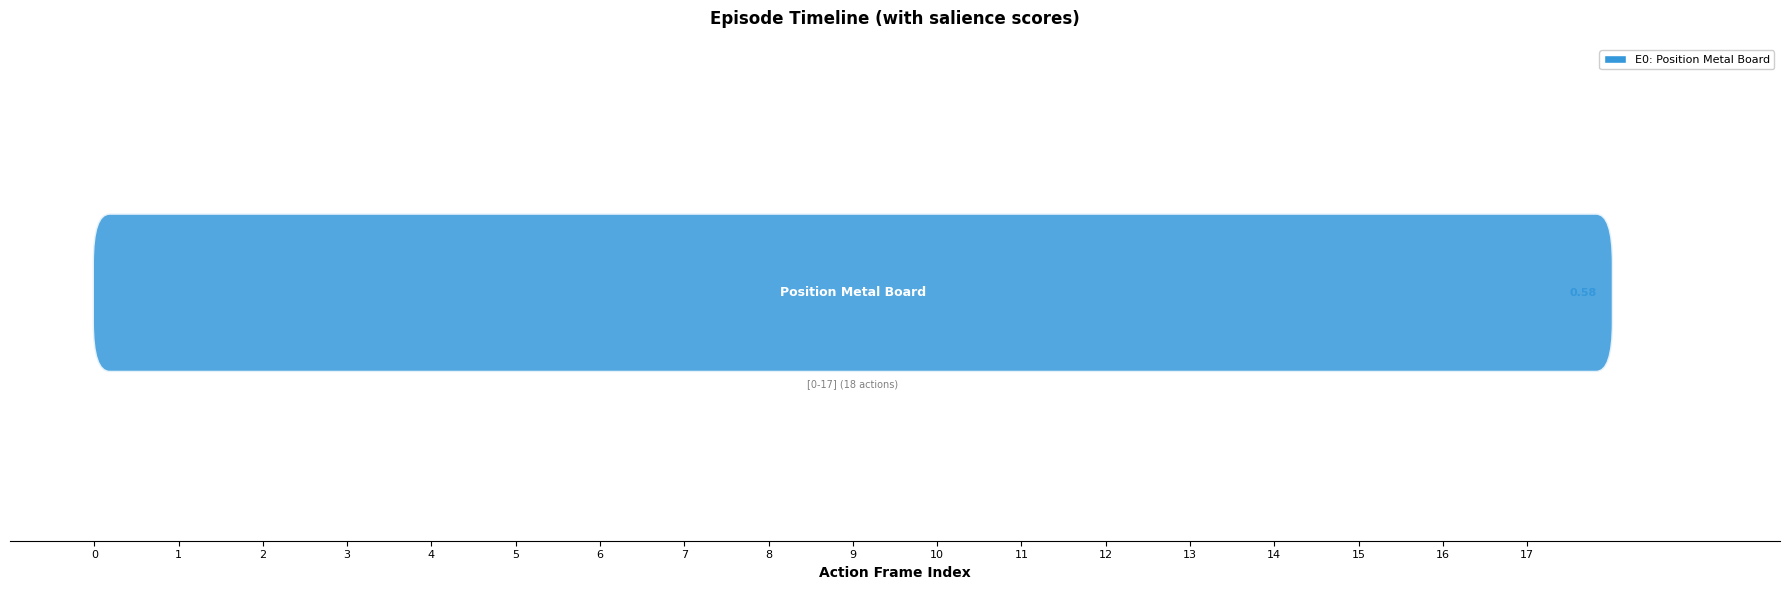


##################################################
# Sample 2/9
##################################################



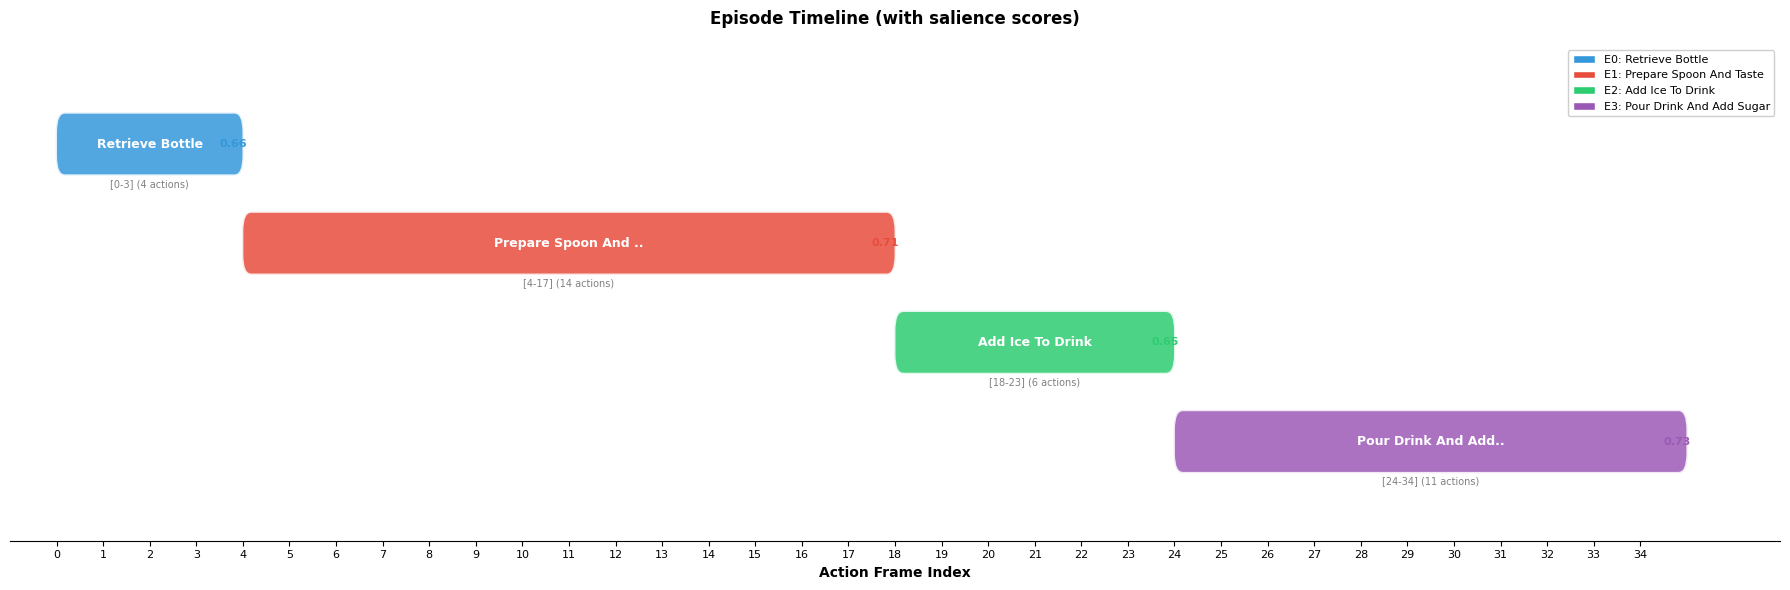

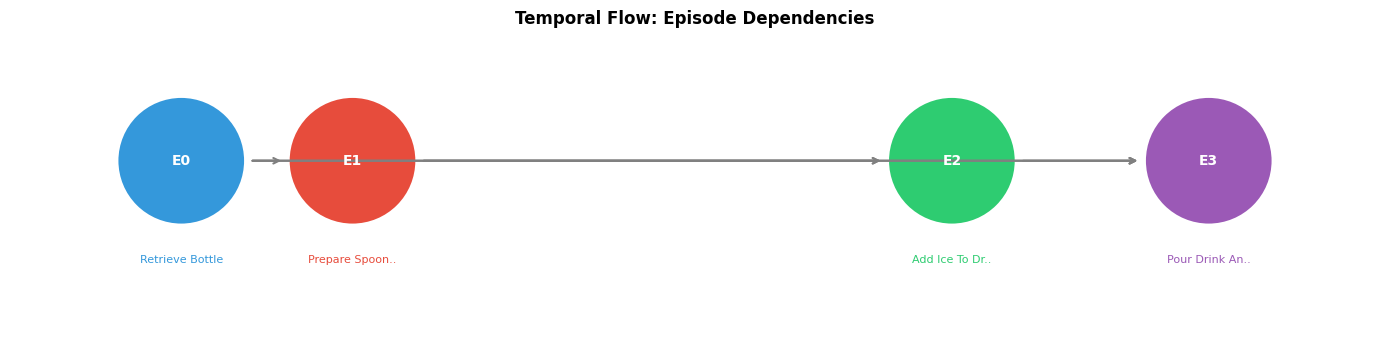


##################################################
# Sample 3/9
##################################################



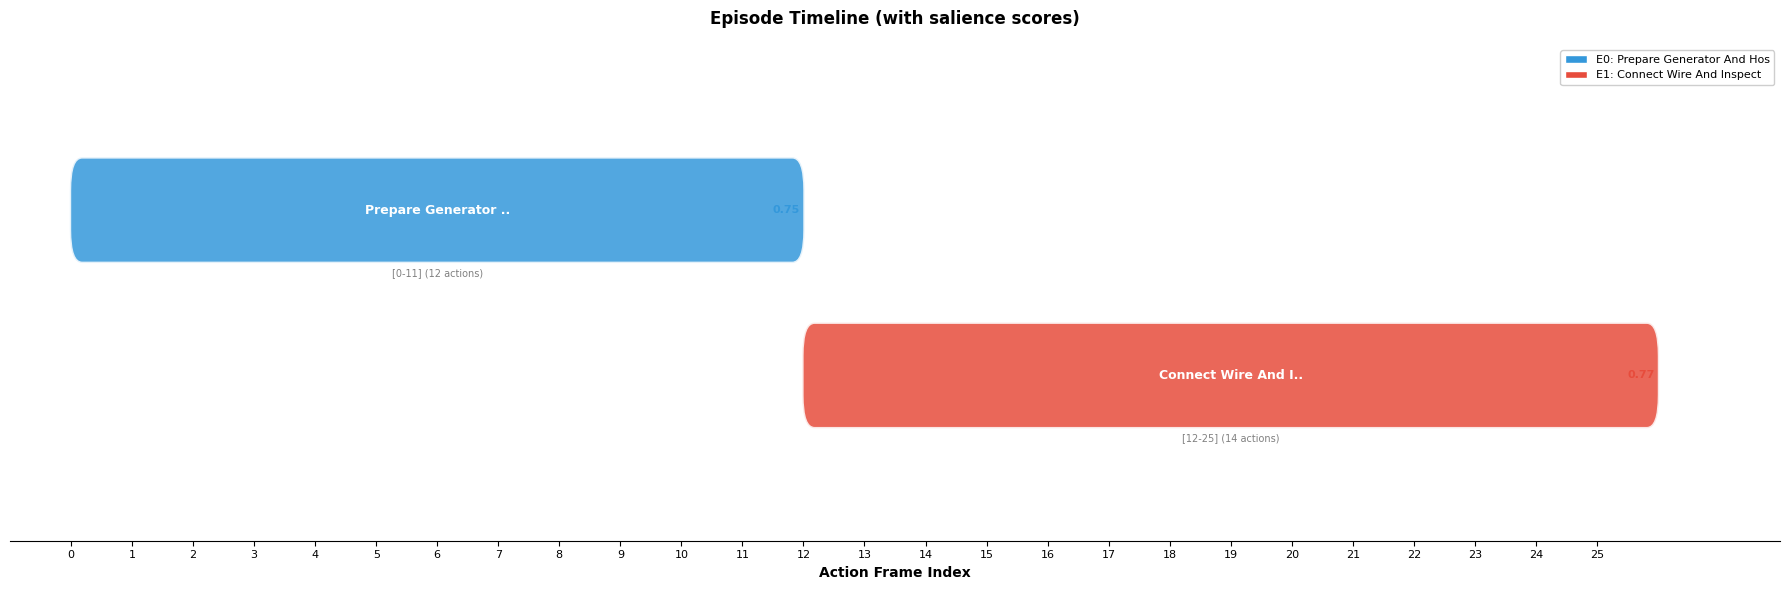

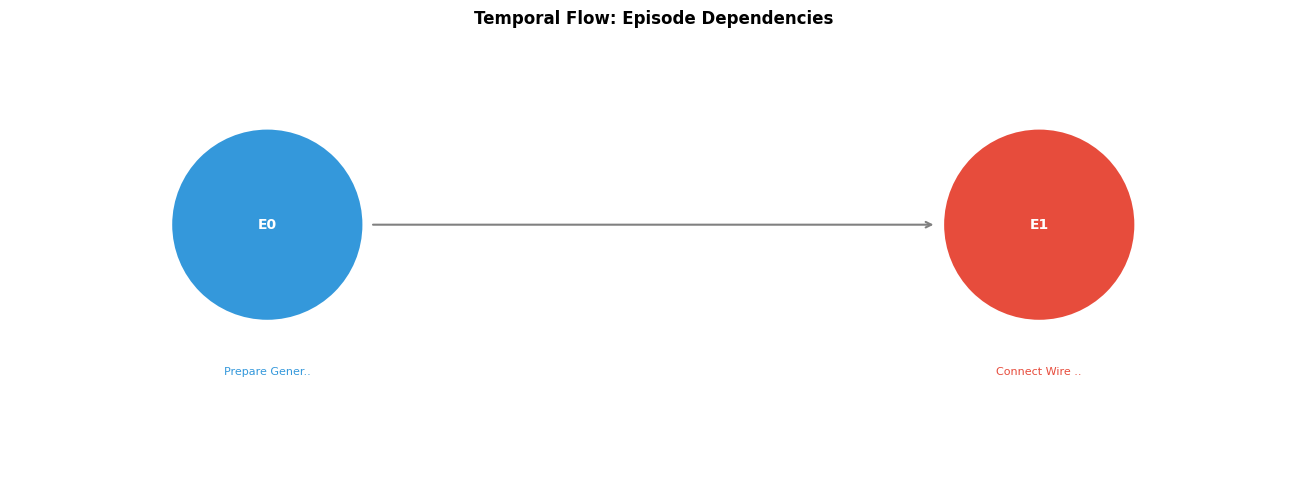


##################################################
# Sample 4/9
##################################################



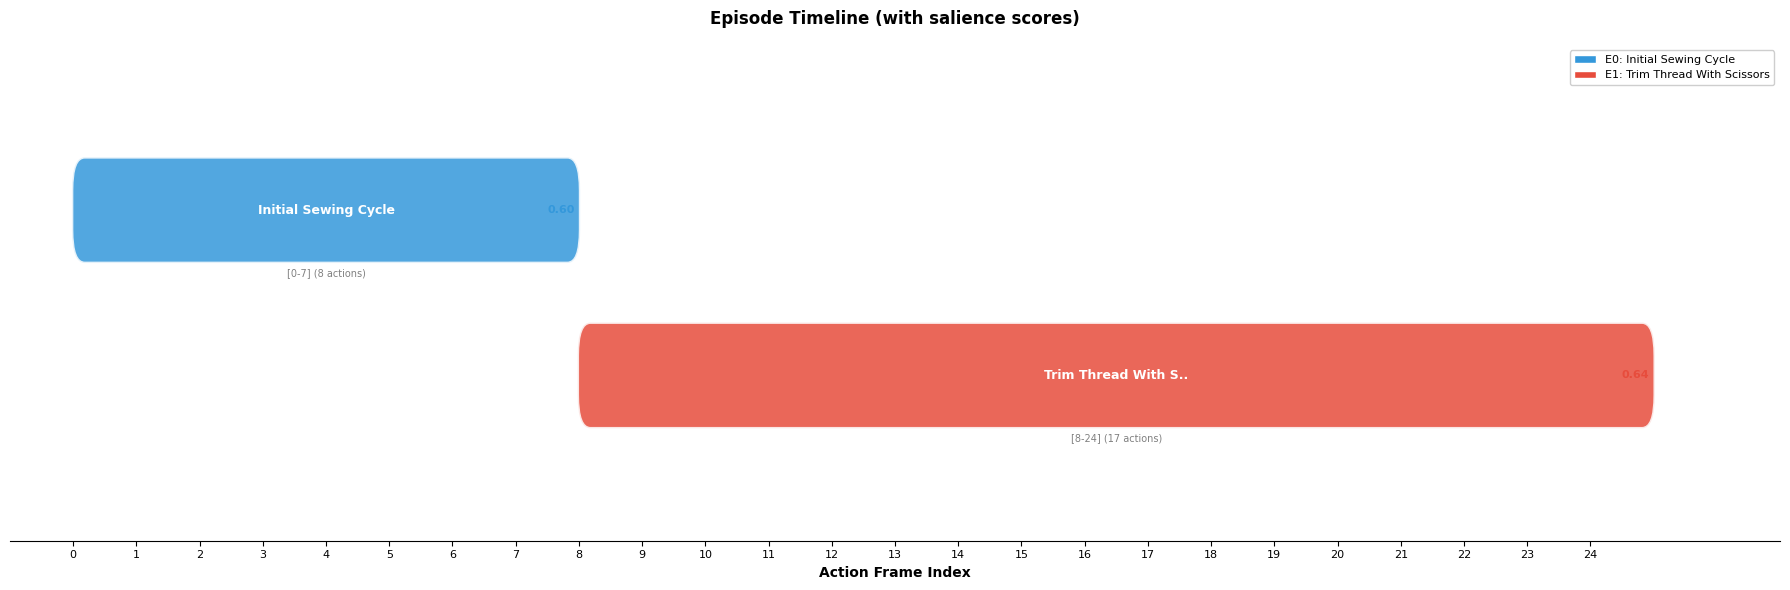

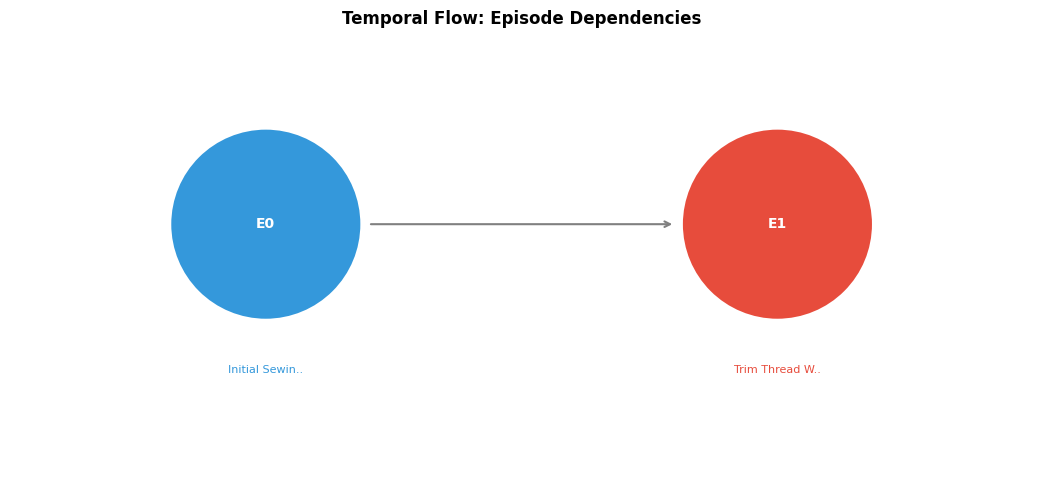


##################################################
# Sample 5/9
##################################################



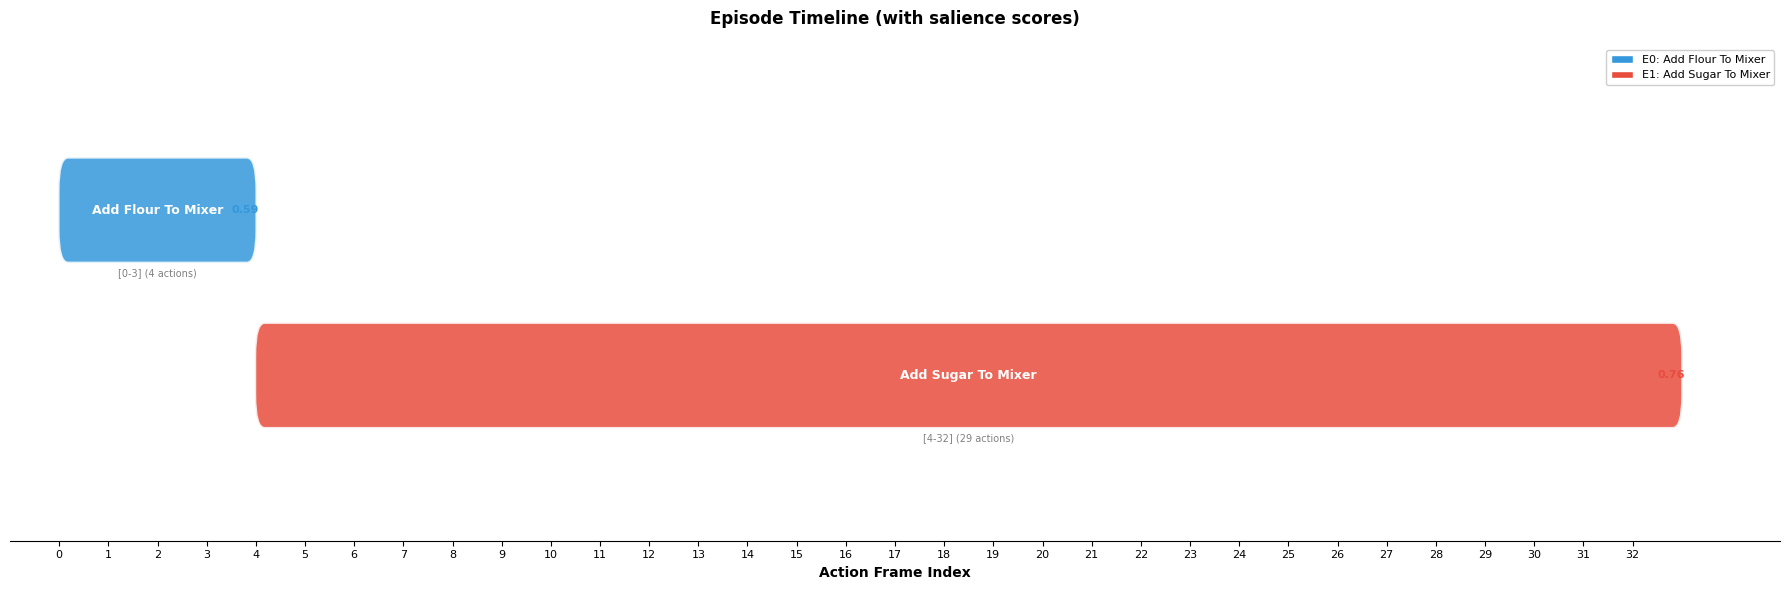

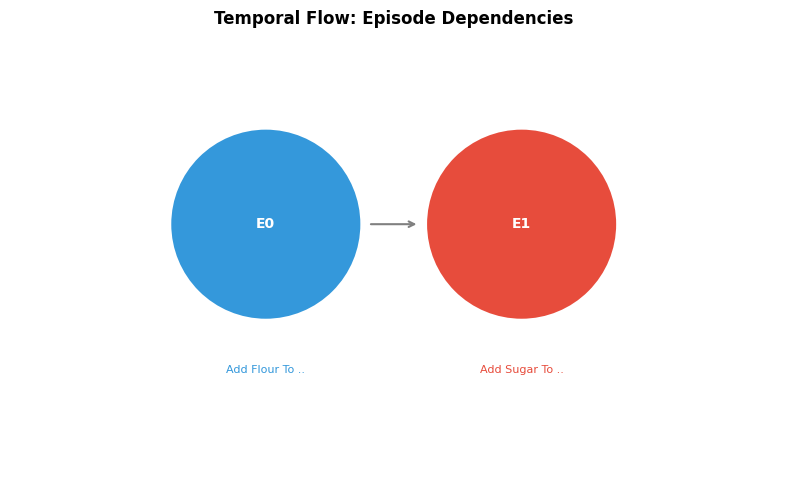


##################################################
# Sample 6/9
##################################################



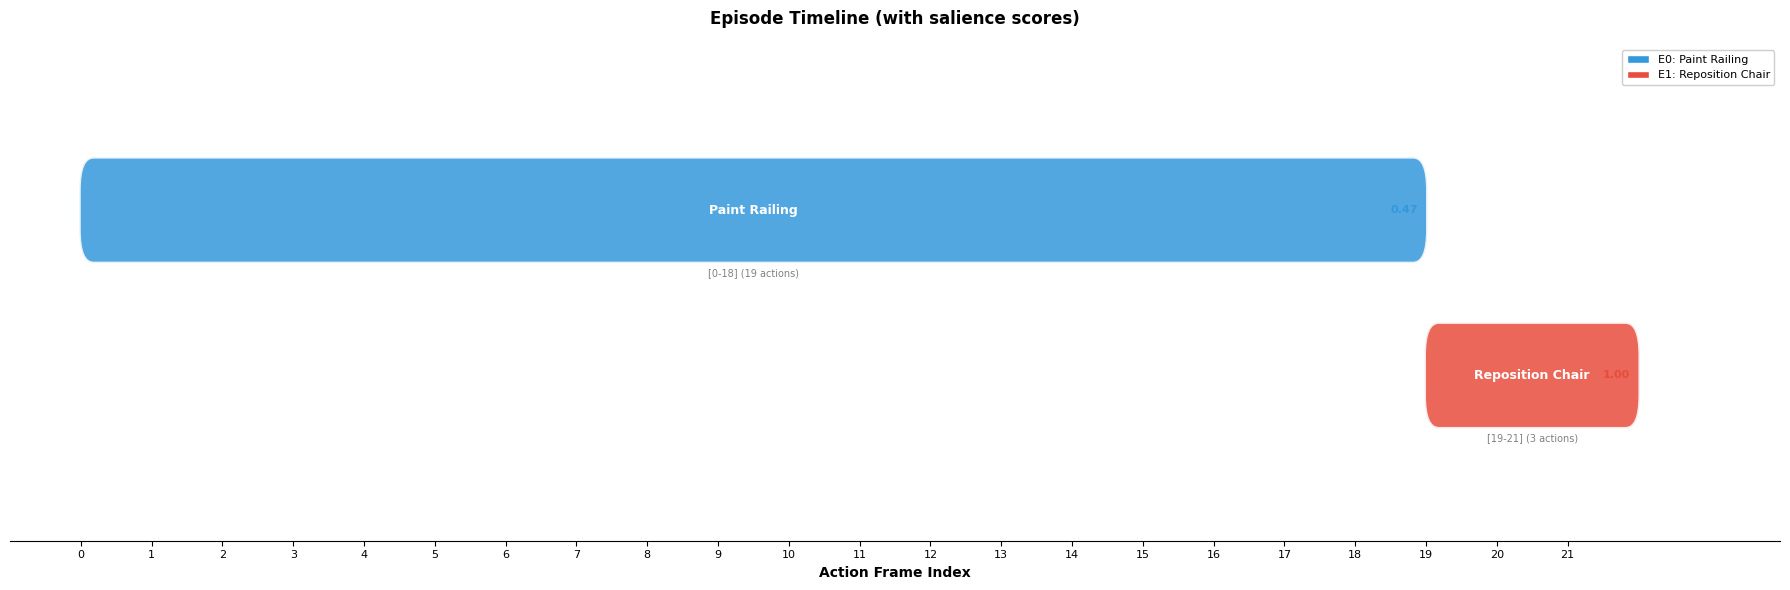

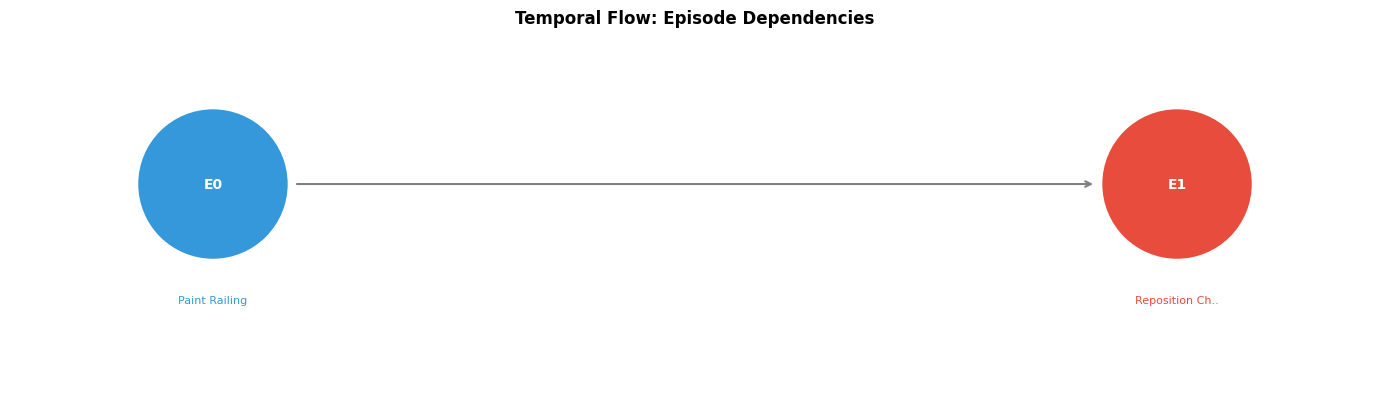


##################################################
# Sample 7/9
##################################################



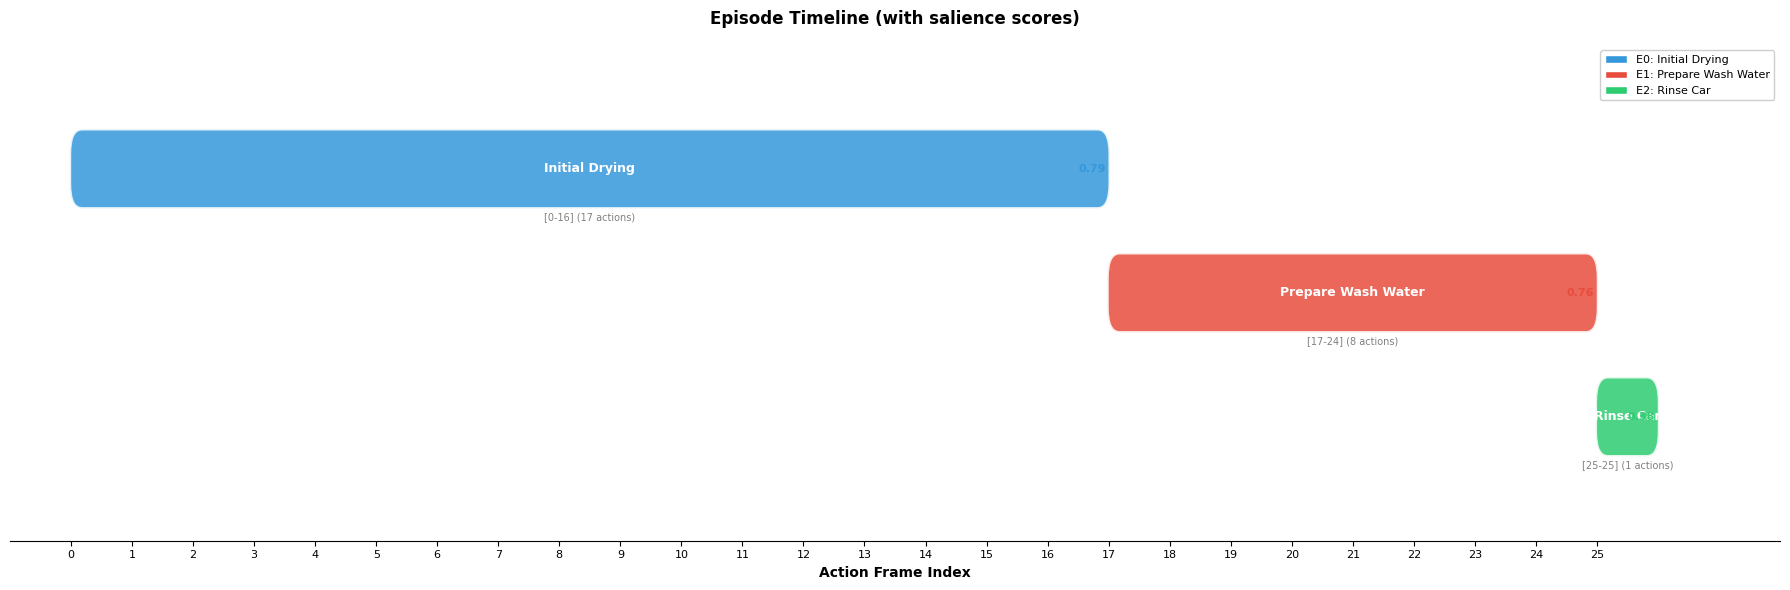

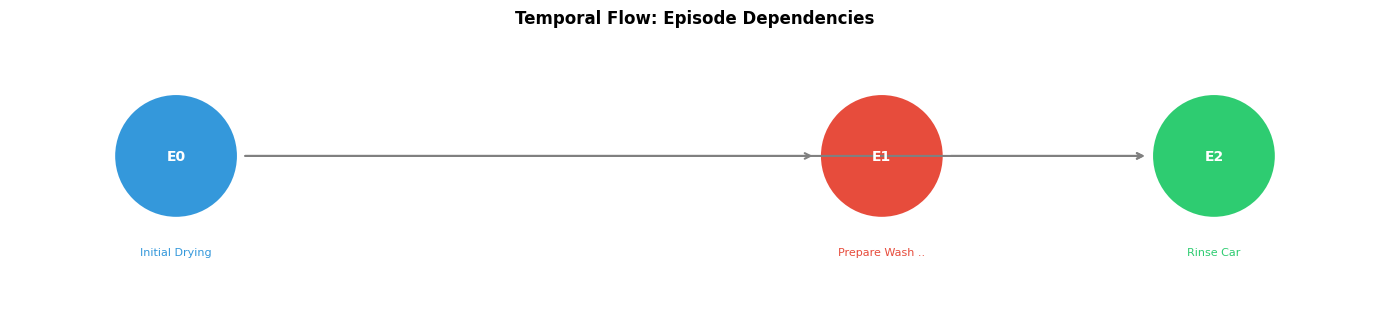


##################################################
# Sample 8/9
##################################################



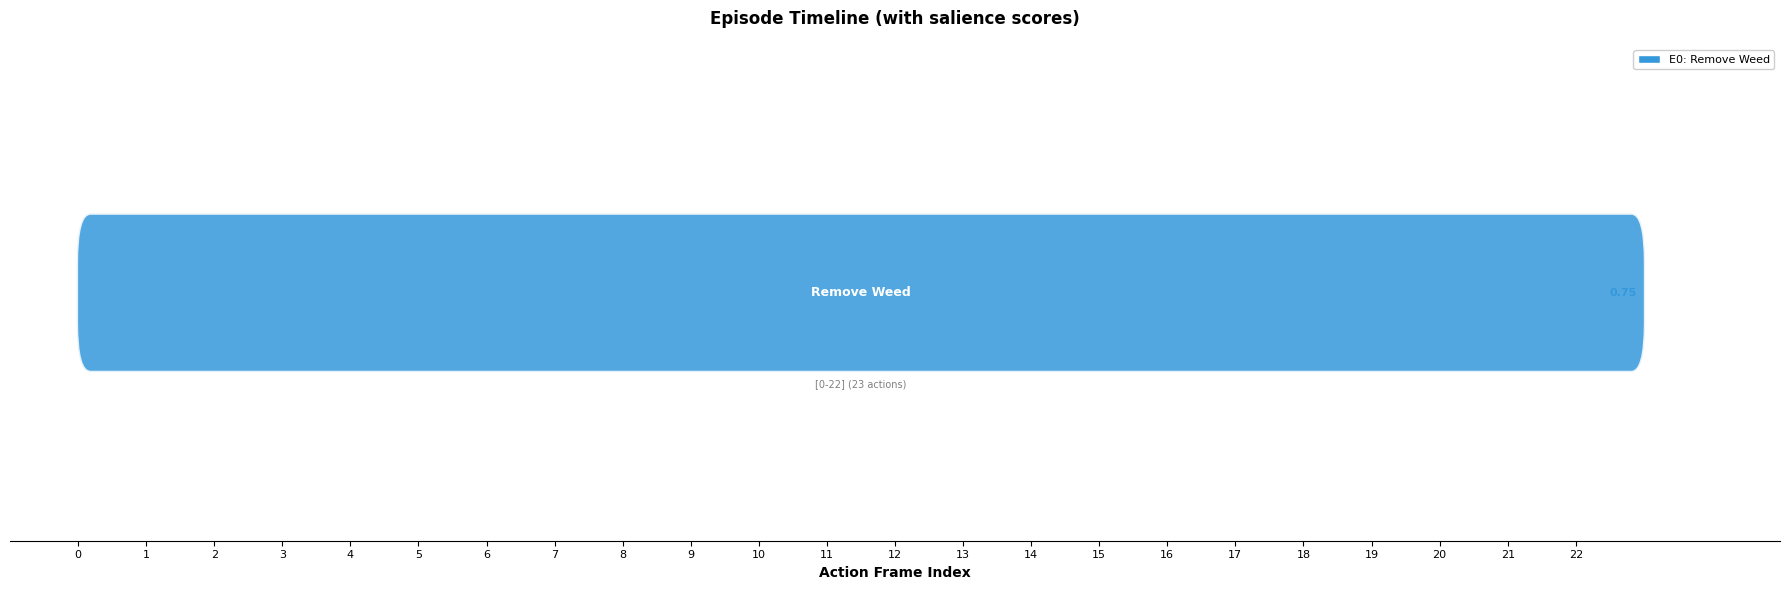


##################################################
# Sample 9/9
##################################################



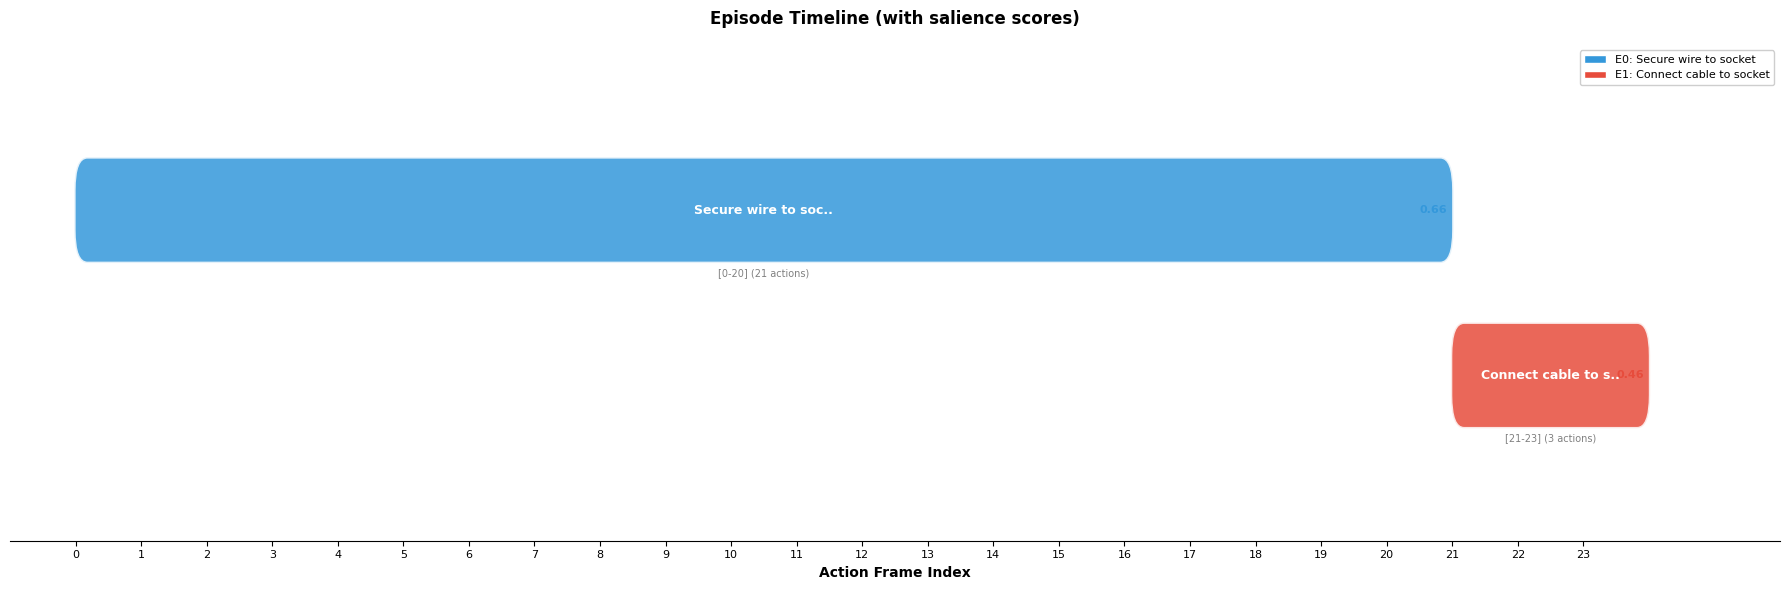

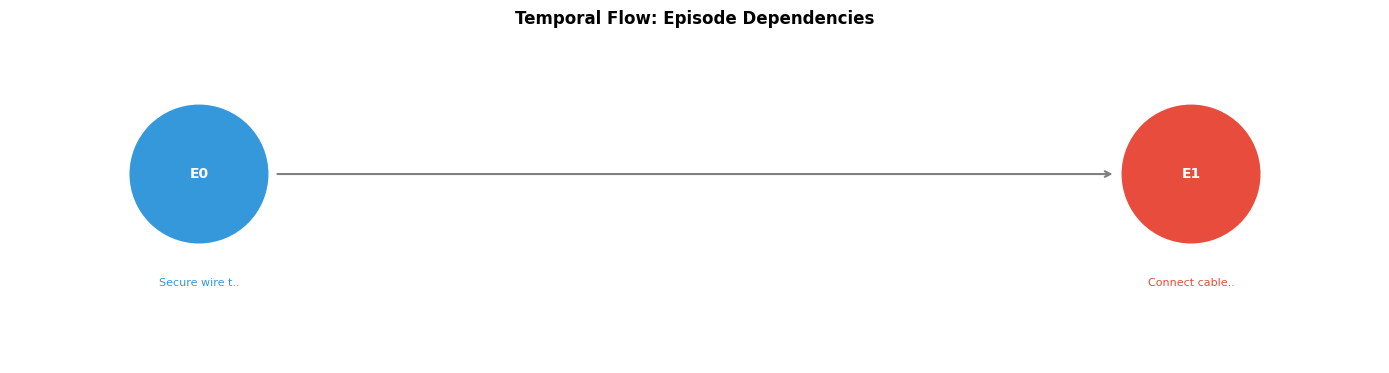

In [3]:
# Visualize all hierarchies
data_ids = list(episodes_data.keys())

for i, data_id in enumerate(data_ids):
    print(f"\n{'#'*50}")
    print(f"# Sample {i+1}/{len(data_ids)}")
    print(f"{'#'*50}\n")
    
    hierarchy = episodes_data[data_id]
    visualize_hierarchy(data_id, hierarchy)

---
## Summary Statistics

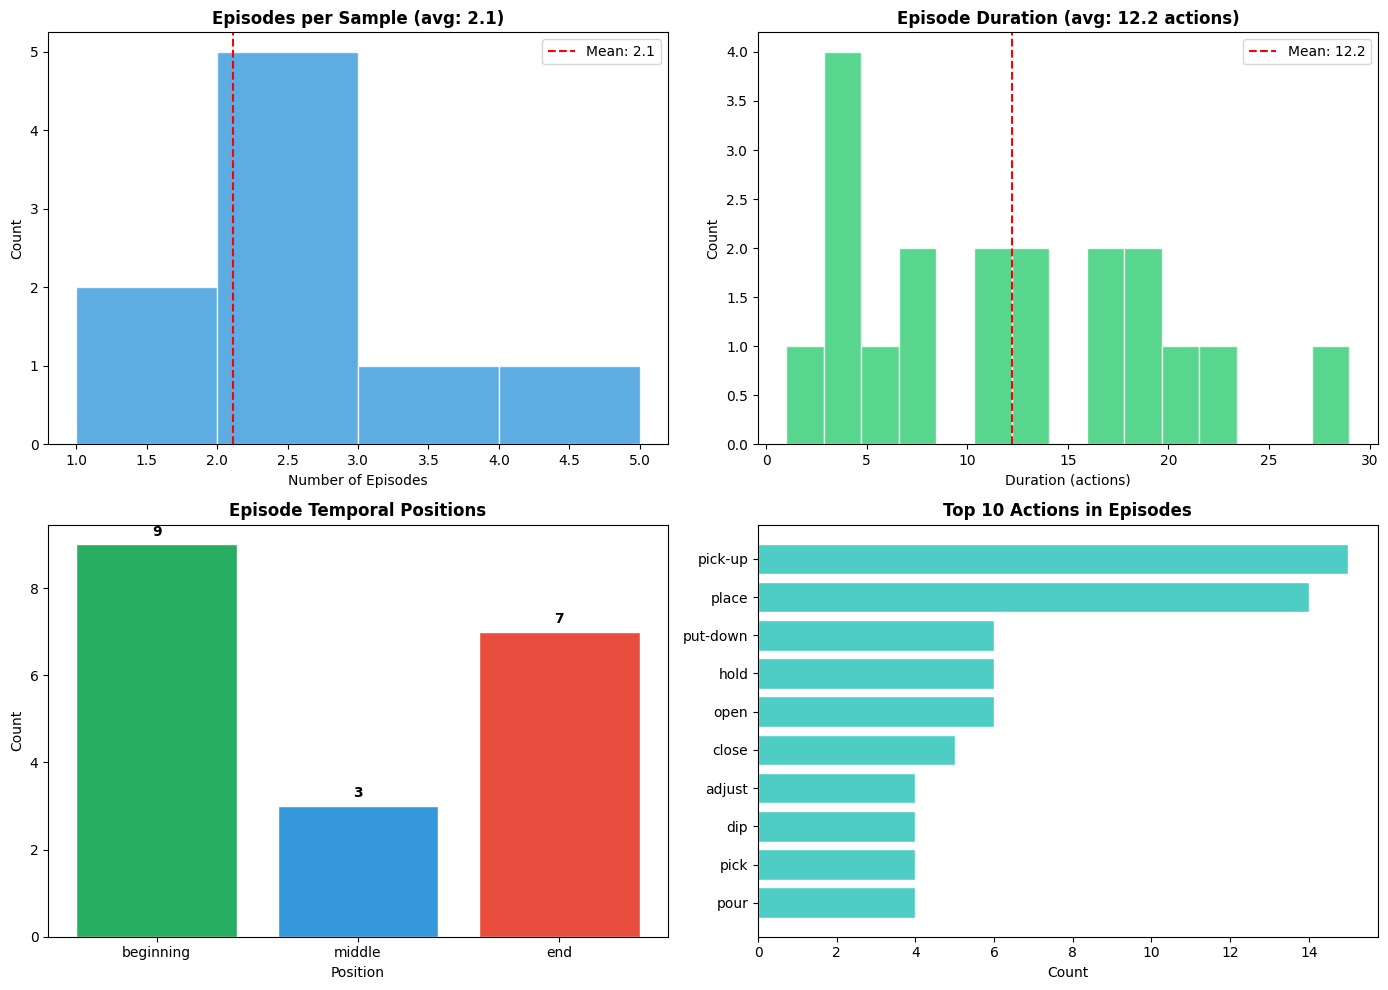


EPISODE HIERARCHY SUMMARY

Total samples: 9
Total episodes: 19
Avg episodes per sample: 2.11
Avg episode duration: 12.21 actions
Avg salience score: 0.669

Top 5 Actions: pick-up, place, put-down, hold, open
Top 5 Objects: bottle, hose, water, brush, spoon


In [4]:
# Summary Statistics
from collections import Counter

# Collect statistics
episode_counts = []
total_durations = []
salience_scores = []
position_counts = Counter()
all_actions = []
all_objects = []

for data_id, hierarchy in episodes_data.items():
    episodes = hierarchy.get('episodes', [])
    episode_counts.append(len(episodes))
    
    for ep in episodes:
        duration = ep.get('time', {}).get('duration', 0)
        total_durations.append(duration)
        
        salience = ep.get('salience_score', 0)
        salience_scores.append(salience)
        
        position = ep.get('temporal_context', {}).get('position', 'unknown')
        position_counts[position] += 1
        
        structure = ep.get('core_structure', {})
        all_actions.extend(structure.get('primary_actions', []))
        all_objects.extend(structure.get('primary_objects', []))

action_counts = Counter(all_actions)
object_counts = Counter(all_objects)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Episodes per sample
ax1 = axes[0, 0]
ax1.hist(episode_counts, bins=range(1, max(episode_counts) + 2), color='#3498DB', edgecolor='white', alpha=0.8)
ax1.set_xlabel('Number of Episodes')
ax1.set_ylabel('Count')
ax1.set_title(f'Episodes per Sample (avg: {np.mean(episode_counts):.1f})', fontsize=12, fontweight='bold')
ax1.axvline(np.mean(episode_counts), color='red', linestyle='--', label=f'Mean: {np.mean(episode_counts):.1f}')
ax1.legend()

# 2. Episode duration distribution
ax2 = axes[0, 1]
ax2.hist(total_durations, bins=15, color='#2ECC71', edgecolor='white', alpha=0.8)
ax2.set_xlabel('Duration (actions)')
ax2.set_ylabel('Count')
ax2.set_title(f'Episode Duration (avg: {np.mean(total_durations):.1f} actions)', fontsize=12, fontweight='bold')
ax2.axvline(np.mean(total_durations), color='red', linestyle='--', label=f'Mean: {np.mean(total_durations):.1f}')
ax2.legend()

# 3. Temporal position distribution
ax3 = axes[1, 0]
positions = list(position_counts.keys())
counts = list(position_counts.values())
colors = [POSITION_COLORS.get(p, '#95A5A6') for p in positions]
bars = ax3.bar(positions, counts, color=colors, edgecolor='white')
ax3.set_xlabel('Position')
ax3.set_ylabel('Count')
ax3.set_title('Episode Temporal Positions', fontsize=12, fontweight='bold')
for bar, count in zip(bars, counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             str(count), ha='center', fontweight='bold')

# 4. Top actions
ax4 = axes[1, 1]
top_actions = action_counts.most_common(10)
actions = [a for a, _ in top_actions]
counts = [c for _, c in top_actions]
bars = ax4.barh(actions[::-1], counts[::-1], color=NODE_COLORS['verb'], edgecolor='white')
ax4.set_xlabel('Count')
ax4.set_title('Top 10 Actions in Episodes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary text
print("\n" + "="*60)
print("EPISODE HIERARCHY SUMMARY")
print("="*60)
print(f"\nTotal samples: {len(episodes_data)}")
print(f"Total episodes: {sum(episode_counts)}")
print(f"Avg episodes per sample: {np.mean(episode_counts):.2f}")
print(f"Avg episode duration: {np.mean(total_durations):.2f} actions")
print(f"Avg salience score: {np.mean(salience_scores):.3f}")
print(f"\nTop 5 Actions: {', '.join([a for a, _ in action_counts.most_common(5)])}")
print(f"Top 5 Objects: {', '.join([o for o, _ in object_counts.most_common(5)])}")
print("="*60)

---
## Interactive Sample Selector

Showing sample 1/9


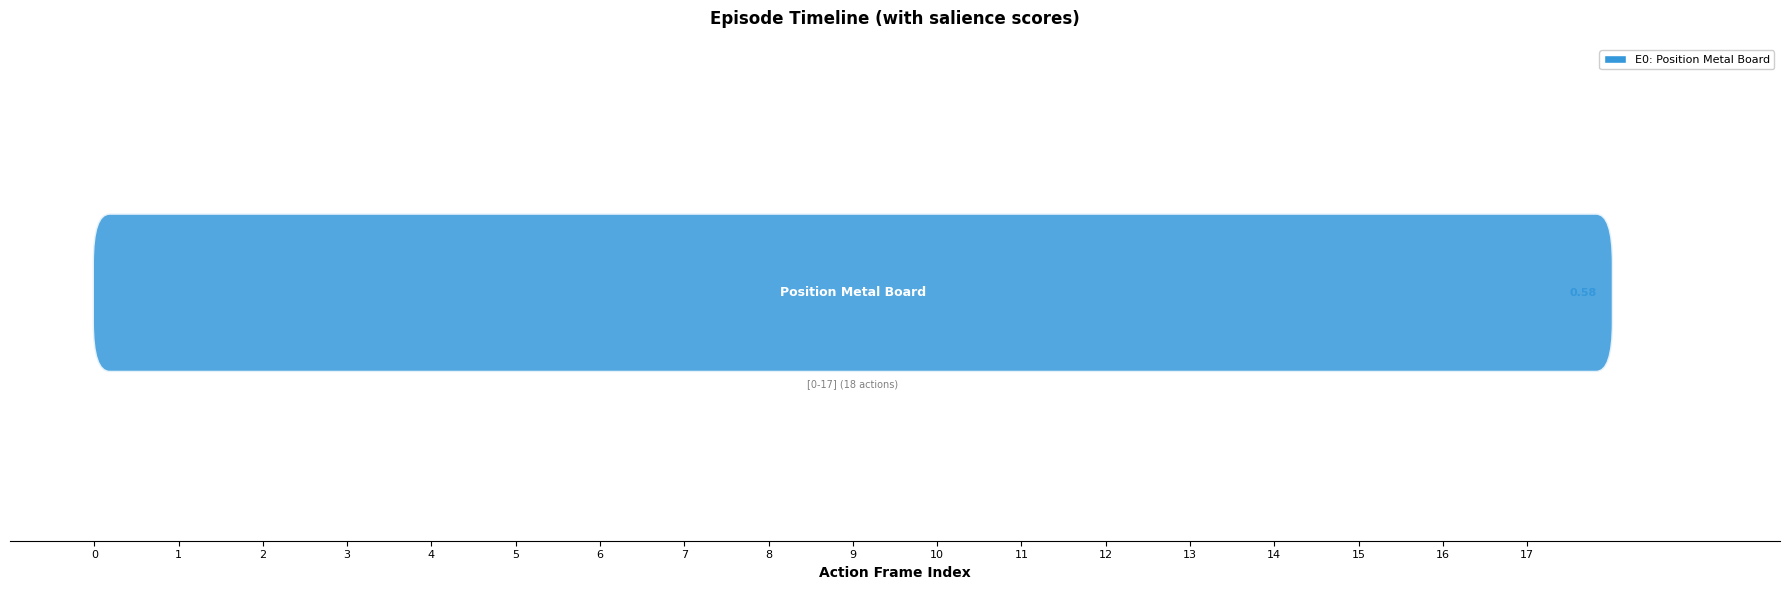

In [5]:
# Interactive selector - change the index to view different samples
SAMPLE_INDEX = 0  # Change this to 0-N

data_ids = list(episodes_data.keys())

if 0 <= SAMPLE_INDEX < len(data_ids):
    data_id = data_ids[SAMPLE_INDEX]
    hierarchy = episodes_data[data_id]
    print(f"Showing sample {SAMPLE_INDEX + 1}/{len(data_ids)}")
    visualize_hierarchy(data_id, hierarchy)
else:
    print(f"Invalid index. Please use 0-{len(data_ids)-1}")